<a href="https://colab.research.google.com/github/g185/AMLrepository/blob/main/AML_Project_Giuliano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Download and unzip Dataset***


*   Create folders
*   Download Recipe 5K + Annotations in drive
*   Unzip files in folder



In [ ]:
#Create folders for models and datasets
!mkdir "/content/drive/My Drive/RecipeNet" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/download" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/extracted" 
!mkdir "/content/drive/My Drive/RecipeNet/datasets/preprocessed" 
!mkdir "/content/drive/My Drive/RecipeNet/model" 

#Scarica dataset
#Trascina i 3 zip

#Unzip
"""
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/new_right_train.zip" -d "/content/drive/My Drive/RecipeNet_g/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/archive.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"
!unzip "/content/drive/My Drive/RecipeNet/datasets/download/Ingredients101.zip" -d "/content/drive/My Drive/RecipeNet/datasets/extracted"

"""


#***Imports and Drive Mount***

In [ ]:
#Imports
import sys
import time
import os
import json
import numpy as np 
import pandas as pd 
from tqdm import tqdm, tqdm_notebook, tnrange
import sys
import cv2
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from glob import glob
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict


#Cuda
device = torch.device("cuda")
torch.manual_seed(42) # try and make the results more reproducible
print(torch.cuda.get_device_name(0))

#Drive Mount
from google.colab import drive
drive.mount('/content/drive')


Tesla P100-PCIE-16GB
Mounted at /content/drive


#***Project Parameters***


In [ ]:
params = {}

#DATASET KEYWORD
params["dataset"] = "Recipe1M"

#NEURAL NETWORK PARAMS
params["freezed_layers"] = 8

#GENERAL TRAINING PARAMS
params["epochs"] = 8
params["batch_size"] = 64
params["img_size"] = (384,384)

#FAST TRAINING SETTINGS
params["fast_training"] = True
params["train_df_size"] = 1200
params["val_df_size"] = 1200
params["test_df_size"] = 1200

#DATASET SETTINGS
params["root"] = "/content/drive/My Drive/RecipeNet/"
if params["dataset"] == "Recipe5k":
    params["images_dir"] = params["root"] + "datasets/extracted/images/" 
    params["ingredients_per_class"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/ingredients_simplified.txt" 
    params["classes"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/classes.txt" 
    params["baseIngredients_dir"] = params["root"] + "datasets/extracted/Ingredients101/ingredients_simplification/baseIngredients.txt" 
    params["annotations_path"] = params["root"] + "datasets/extracted/Ingredients101/Annotations/"
elif params["dataset"] == "Recipe1M":
    params["images_dir"] = params["root"] + "datasets/extracted/new_right_train/" 
    params["annotations_path"] = params["root"] + "datasets/extracted/Annotations_1M/"
    params["ingredients_per_class"] = params["root"] + "datasets/extracted/Annotations_1M/ingr.txt" 
    params["classes"] = params["root"] + "datasets/extracted/Annotations_1M/newclasses.txt" 
    params["baseIngredients_dir"] = params["root"] + "datasets/extracted/Annotations_1M/baseIngredients.txt" 
    params["annotations_path"] = params["root"] + "datasets/extracted/Annotations_1M/"
else:
    print("Invalid Dataset Keyword, try with Recipe1M or Recipe5k")


#***Data extraction and preprocessing***


Dataset Loading

In [ ]:
#Ingredients x class
f = open(params["ingredients_per_class"], "r")
ingredients = f.read().split('\n')
f.close()

#Classes
f = open(params["classes"], "r")
classes = f.read().split('\n')
f.close()

#Ingredients
f = open(params["baseIngredients_dir"], "r")
base_ing = f.read().split('\n')
base_ing = base_ing[0].split(",")
f.close()

#train images
f = open(params["root"] + "datasets/extracted/Annotations_1M/train_imgs.txt", "r")
train_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Annotations_1M/train_lab.txt", "r")
train_labels = f.read().split('\n')
f.close()

#validation images
f = open(params["root"] + "datasets/extracted/Annotations_1M/val_imgs.txt", "r")
val_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Annotations_1M/val_lab.txt", "r")
val_labels = f.read().split('\n')
f.close()

#test images
f = open(params["root"] + "datasets/extracted/Annotations_1M/test_imgs.txt", "r")
test_images = f.read().split('\n')
f.close()
f = open(params["root"] + "datasets/extracted/Annotations_1M/test_lab.txt", "r")
test_labels = f.read().split('\n')
f.close()

['abaaa34e8a/0035498b8f', 'abaaa34e8a/00df971801', 'abaaa34e8a/066678055e', 'abaaa34e8a/066ec853e4', 'abaaa34e8a/0aec8e4dcd', 'abaaa34e8a/0da78b2496', 'abaaa34e8a/11c8ab8249', 'abaaa34e8a/11dc55ff6a', 'abaaa34e8a/127fe16291', 'abaaa34e8a/16da2ef4b8']


Dataframes Creation

In [ ]:
#list of string in list of list of tokens
new_ingredients = [arr.split(",") for arr in ingredients]

#binary encode ingredients
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(new_ingredients),columns=mlb.classes_) 
df["target"] = classes
food_dict = df
train_images = [params["images_dir"] + s + ".jpg" for s in train_images]
all_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})
val_images = [params["images_dir"] + s + ".jpg" for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})
test_images = [params["images_dir"] + s + ".jpg" for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})
all_img_df = all_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]



all_img_df['class_name'] = all_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
val_img_df['class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df['class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])

#food_dict = food_dict.drop('', 1)


['abaaa34e8a/0035498b8f', 'abaaa34e8a/00df971801', 'abaaa34e8a/066678055e', 'abaaa34e8a/066ec853e4', 'abaaa34e8a/0aec8e4dcd', 'abaaa34e8a/0da78b2496', 'abaaa34e8a/11c8ab8249', 'abaaa34e8a/11dc55ff6a', 'abaaa34e8a/127fe16291', 'abaaa34e8a/16da2ef4b8']
['/content/drive/My Drive/RecipeNet/datasets/extracted/new_right_train/abaaa34e8a/0035498b8f.jpg', '/content/drive/My Drive/RecipeNet/datasets/extracted/new_right_train/abaaa34e8a/00df971801.jpg', '/content/drive/My Drive/RecipeNet/datasets/extracted/new_right_train/abaaa34e8a/066678055e.jpg', '/content/drive/My Drive/RecipeNet/datasets/extracted/new_right_train/abaaa34e8a/066ec853e4.jpg', '/content/drive/My Drive/RecipeNet/datasets/extracted/new_right_train/abaaa34e8a/0aec8e4dcd.jpg', '/content/drive/My Drive/RecipeNet/datasets/extracted/new_right_train/abaaa34e8a/0da78b2496.jpg', '/content/drive/My Drive/RecipeNet/datasets/extracted/new_right_train/abaaa34e8a/11c8ab8249.jpg', '/content/drive/My Drive/RecipeNet/datasets/extracted/new_righ

Train Dataframe

In [ ]:
#Dataframe for train images
new_data = []
for index, row in all_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = class_id
    #print(binary_encod["class_id"])
    #print((list(binary_encod.columns.values)))
    #print(len(np.array(binary_encod)[0]))
    new_data.append(np.array(binary_encod)[0])


    
col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Validation Dataframe

In [ ]:
val_data = []
for index, row in val_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    val_data.append(np.array(binary_encod)[0])
val_df = pd.DataFrame(val_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Test Dataframe

In [ ]:
test_data = []
for index, row in test_img_df.iterrows():
    #get binary encoding ingredients from lookup
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    binary_encod = food_dict.loc[food_dict["target"] == food]
    binary_encod["path"] = path
    binary_encod["class_id"] = int(class_id)
    test_data.append(np.array(binary_encod)[0])


test_df = pd.DataFrame(test_data, columns = col_names)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#***DataGenerator***


In [ ]:
class DataWrapper(data.Dataset):
    ''' Data wrapper for pytorch's data loader function '''
    def __init__(self, image_df, resize):
        self.dataset = image_df
        self.resize = resize

    def __getitem__(self, index):
        c_row = self.dataset.iloc[index]
        target_arr = []
        for item in c_row[targets].values:
            target_arr.append(item)
        #print(target_arr)
        image_path, target = c_row['path'], torch.from_numpy(np.array(target_arr)).float()  #image and target
        #read as rgb image, resize and convert to range 0 to 1
        image = cv2.imread(image_path, 1)
        #print(image_path, image)
        if self.resize:
            image = cv2.resize(image, params["img_size"])/255.0 
        else:
            image = image/255.0
        image = (torch.from_numpy(image.transpose(2,0,1))).float() #NxCxHxW
        return image, target

    def __len__(self):
        return self.dataset.shape[0]

#***Trasfer Learning Model:ResNet***

In [ ]:
col_names = list(train_df.columns.values)
targets = col_names[:-3]

model = models.resnet50(pretrained=True)

output = len(targets)
model.fc = nn.Linear(model.fc.in_features, output)

layer = 0
for name, child in model.named_children():
    layer += 1
    if layer < params["freezed_layers"]:
        for name2, param in child.named_parameters():
            param.requires_grad = False

#***Trasfer Learning Model:GoogleNet***

#***Training***

Define Hamming Score

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

Training Settings

In [ ]:
if params["fast_training"] == True:
    train_df = train_df[params["train_df_size"]]
    val_df = val_df[params["val_df_size"]]
    test_df = test_df[params["test_df_size"]]
            
print(len(val_df))
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())



1200


Dataset Loaders

In [ ]:
train_dataset = DataWrapper(train_df, True)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

val_dataset = DataWrapper(val_df, True)
val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

test_dataset = DataWrapper(test_df, True)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True, batch_size=params["batch_size"], pin_memory=False)

Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  del sys.path[0]


Epoch  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training loss:  0.001960674983759721  train acc:  0.9497343522561863


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Test set accuracy:  0.9594177583697234
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904], 'macro_train': [0.061397535062837946], 'weighted_train': [0.4757591459895073], 'hamming_train': [0.44747833502100454], 'samples_test': [0.3029882856240943], 'macro_test': [0.04427244332902501], 'weighted_test': [0.27268250562990975], 'hamming_test': [0.20699838082383626]})
Epoch  1



Training loss:  0.0005473308529083927  train acc:  0.9861644832605532



Test set accuracy:  0.9511499272197962
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904, 0.7485702424230101], 'macro_train': [0.061397535062837946, 0.1546774451975742], 'weighted_train': [0.4757591459895073, 0.7395628741361059], 'hamming_train': [0.44747833502100454, 0.673908632070687], 'samples_test': [0.3029882856240943, 0.261791753559729], 'macro_test': [0.04427244332902501, 0.05194461999297758], 'weighted_test': [0.27268250562990975, 0.2554843762573207], 'hamming_test': [0.20699838082383626, 0.17634881678470785]})
Epoch  2



Training loss:  0.0003542573618081709  train acc:  0.9912627365356623



Test set accuracy:  0.9609534206695779
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904, 0.7485702424230101, 0.8422931409448347], 'macro_train': [0.061397535062837946, 0.1546774451975742, 0.21084765382916998], 'weighted_train': [0.4757591459895073, 0.7395628741361059, 0.8549197304817281], 'hamming_train': [0.44747833502100454, 0.673908632070687, 0.788233807780054], 'samples_test': [0.3029882856240943, 0.261791753559729, 0.3107655796749206], 'macro_test': [0.04427244332902501, 0.05194461999297758, 0.05911609380553541], 'weighted_test': [0.27268250562990975, 0.2554843762573207, 0.28592607148599586], 'hamming_test': [0.20699838082383626, 0.17634881678470785, 0.21822273820346405]})
Epoch  3



Training loss:  0.0002725450710083048  train acc:  0.9936826783114993



Test set accuracy:  0.9612190684133916
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904, 0.7485702424230101, 0.8422931409448347, 0.8883928145663101], 'macro_train': [0.061397535062837946, 0.1546774451975742, 0.21084765382916998, 0.22682082566082556], 'weighted_train': [0.4757591459895073, 0.7395628741361059, 0.8549197304817281, 0.895942472256021], 'hamming_train': [0.44747833502100454, 0.673908632070687, 0.788233807780054, 0.8454222090008661], 'samples_test': [0.3029882856240943, 0.261791753559729, 0.3107655796749206, 0.3230100159900808], 'macro_test': [0.04427244332902501, 0.05194461999297758, 0.05911609380553541, 0.05645129604963842], 'weighted_test': [0.27268250562990975, 0.2554843762573207, 0.28592607148599586, 0.3046982762410147], 'hamming_test': [0.20699838082383626, 0.17634881678470785, 0.21822273820346405, 0.22614536132353816]})
Epoch  4



Training loss:  0.0002129915791253249  train acc:  0.9951055312954876



Test set accuracy:  0.9613136826783115
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904, 0.7485702424230101, 0.8422931409448347, 0.8883928145663101, 0.9188208645615323], 'macro_train': [0.061397535062837946, 0.1546774451975742, 0.21084765382916998, 0.22682082566082556, 0.23971966348971493], 'weighted_train': [0.4757591459895073, 0.7395628741361059, 0.8549197304817281, 0.895942472256021, 0.9223344525140423], 'hamming_train': [0.44747833502100454, 0.673908632070687, 0.788233807780054, 0.8454222090008661, 0.8840771092333591], 'samples_test': [0.3029882856240943, 0.261791753559729, 0.3107655796749206, 0.3230100159900808, 0.3639997867123807], 'macro_test': [0.04427244332902501, 0.05194461999297758, 0.05911609380553541, 0.05645129604963842, 0.060853494950493636], 'weighted_test': [0.27268250562990975, 0.2554843762573207, 0.28592607148599586, 0.3046982762410147, 0.35126181870982065], 'hamming_test': [0.20699838082383626, 0.17634881678470785, 0.21822273820346405, 0.


Training loss:  0.0001509933724688987  train acc:  0.9967176128093158



Test set accuracy:  0.9614556040756914
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904, 0.7485702424230101, 0.8422931409448347, 0.8883928145663101, 0.9188208645615323, 0.9429058498076593], 'macro_train': [0.061397535062837946, 0.1546774451975742, 0.21084765382916998, 0.22682082566082556, 0.23971966348971493, 0.2503788600509391], 'weighted_train': [0.4757591459895073, 0.7395628741361059, 0.8549197304817281, 0.895942472256021, 0.9223344525140423, 0.9477317062309366], 'hamming_train': [0.44747833502100454, 0.673908632070687, 0.788233807780054, 0.8454222090008661, 0.8840771092333591, 0.917676240018152], 'samples_test': [0.3029882856240943, 0.261791753559729, 0.3107655796749206, 0.3230100159900808, 0.3639997867123807, 0.3439661435917652], 'macro_test': [0.04427244332902501, 0.05194461999297758, 0.05911609380553541, 0.05645129604963842, 0.060853494950493636, 0.05953569068964611], 'weighted_test': [0.27268250562990975, 0.2554843762573207, 0.28592607148599586, 0.30


Training loss:  0.00011341221281327307  train acc:  0.9976819505094614



Test set accuracy:  0.961910480349345
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904, 0.7485702424230101, 0.8422931409448347, 0.8883928145663101, 0.9188208645615323, 0.9429058498076593, 0.9634466398594579], 'macro_train': [0.061397535062837946, 0.1546774451975742, 0.21084765382916998, 0.22682082566082556, 0.23971966348971493, 0.2503788600509391, 0.2575855086521884], 'weighted_train': [0.4757591459895073, 0.7395628741361059, 0.8549197304817281, 0.895942472256021, 0.9223344525140423, 0.9477317062309366, 0.9642949057406538], 'hamming_train': [0.44747833502100454, 0.673908632070687, 0.788233807780054, 0.8454222090008661, 0.8840771092333591, 0.917676240018152, 0.9437555083805084], 'samples_test': [0.3029882856240943, 0.261791753559729, 0.3107655796749206, 0.3230100159900808, 0.3639997867123807, 0.3439661435917652, 0.34687073890786757], 'macro_test': [0.04427244332902501, 0.05194461999297758, 0.05911609380553541, 0.05645129604963842, 0.060853494950493636, 0.0595


Training loss:  8.162437569505225e-05  train acc:  0.9983806404657933



Test set accuracy:  0.9626237263464338
f1_scores defaultdict(<class 'list'>, {'samples_train': [0.5343766893880904, 0.7485702424230101, 0.8422931409448347, 0.8883928145663101, 0.9188208645615323, 0.9429058498076593, 0.9634466398594579, 0.9747561771503351], 'macro_train': [0.061397535062837946, 0.1546774451975742, 0.21084765382916998, 0.22682082566082556, 0.23971966348971493, 0.2503788600509391, 0.2575855086521884, 0.2613831377734825], 'weighted_train': [0.4757591459895073, 0.7395628741361059, 0.8549197304817281, 0.895942472256021, 0.9223344525140423, 0.9477317062309366, 0.9642949057406538, 0.9747988477384645], 'hamming_train': [0.44747833502100454, 0.673908632070687, 0.788233807780054, 0.8454222090008661, 0.8840771092333591, 0.917676240018152, 0.9437555083805084, 0.9606424721112222], 'samples_test': [0.3029882856240943, 0.261791753559729, 0.3107655796749206, 0.3230100159900808, 0.3639997867123807, 0.3439661435917652, 0.34687073890786757, 0.348768680062789], 'macro_test': [0.0442724433

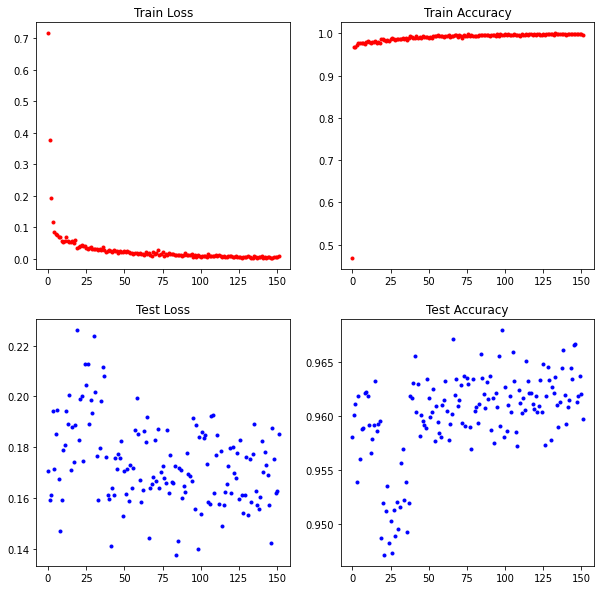

In [ ]:
#Definisco i plots
train_results = defaultdict(list)
train_iter, test_iter, best_acc = 0,0,0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Test Loss')
ax4.set_title('Test Accuracy')

#dizionario f1 scores
f1_scores = defaultdict(list)

for i in tnrange(params["epochs"], desc='Epochs'):
    print("Epoch ",i)
    ## Train Phase
    #Model switches to train phase
    model.train() 
    
    #azzera ris
    all_outputs = []
    all_targets = []

    # Running through all mini batches in the dataset
    count, loss_val, correct, total = train_iter, 0, 0, 0
    for img_data, target in tqdm_notebook(train_loader, desc='Training'):  

        #load batch  
        img_data, target = img_data.to(device), target.to(device)

        #FWD prop
        output = model(img_data) 

        #Cross entropy loss
        loss = criterion(output, target) 

        #current loss 
        c_loss = loss.data.item()

        #plot current loss
        ax1.plot(count, c_loss, 'r.')

        #accumulate loss for training phase
        loss_val += c_loss

        optimizer.zero_grad() #Zero out any cached gradients
        loss.backward() #Backward pass
        optimizer.step() #Update the weights

        #number of outputs, batch * labels
        total_batch = (target.size(0) * target.size(1))
        total += total_batch

        #output and targets
        output_data = torch.sigmoid(output)>=0.5
        target_data = (target==1.0)
        
        #carica i risultati e i target
        for arr1,arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))

        #accuracy
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        
        #plot accuracy
        ax2.plot(count, c_acc/total_batch, 'r.')

        #accumula accuracy
        correct += c_acc

        #accumula numero di steps per epoch
        count +=1
        
    #prendi i risultati dell'ultimo training
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)

    #Training Metrics
    #______________________________________________________________________________________________________
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_train"].append(f1score_samples)
    f1_scores["macro_train"].append(f1score_macro)
    f1_scores["weighted_train"].append(f1score_weighted)
    f1_scores["hamming_train"].append(hamming)
    #____________________________________________________________________________________________________________________
    #Training loss val è loss per image,
    #train_iter è count, numero di steps, images in training / batch size * epoch number
    #train_acc over training
    train_loss_val, train_iter, train_acc = loss_val/len(train_loader.dataset), count, correct/float(total)
    
    print("Training loss: ", train_loss_val, " train acc: ",train_acc)    
    ## Test Phase
    
    #Model switches to test phase
    model.eval()
    
    all_outputs = []
    all_targets = []
    #Running through all mini batches in the dataset
    count, correct, total, lost_val = test_iter, 0, 0, 0
    for img_data, target in tqdm_notebook(val_loader, desc='Validation'):
        img_data, target = img_data.to(device), target.to(device)
        output = model(img_data)
        loss = criterion(output, target) #Cross entropy loss
        c_loss = loss.data.item()
        ax3.plot(count, c_loss, 'b.')
        loss_val += c_loss
        #Compute accuracy
        #predicted = output.data.max(1)[1] #get index of max
        total_batch = (target.size(0) * target.size(1))
        total += total_batch
        output_data = torch.sigmoid(output)>=0.5
        target_data = (target==1.0)
        #print("Predictions: ", output_data)
        #print("Actual: ", target_data)
        for arr1,arr2 in zip(output_data, target_data):
            all_outputs.append(list(arr1.cpu().numpy()))
            all_targets.append(list(arr2.cpu().numpy()))
        c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
        ax4.plot(count, c_acc/total_batch, 'b.')
        correct += c_acc
        count += 1
    
    #print("Outputs: ", len(all_outputs), " x ", len(all_outputs[0]))
    #print("Targets: ", len(all_targets), " x ", len(all_targets[0]))
    
    #F1 Score
    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)
    f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
    f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
    recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
    hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
    
    f1_scores["samples_test"].append(f1score_samples)
    f1_scores["macro_test"].append(f1score_macro)
    f1_scores["weighted_test"].append(f1score_weighted)
    f1_scores["hamming_test"].append(hamming)
    
    #Accuracy over entire dataset
    test_acc, test_iter, test_loss_val = correct/float(total), count, loss_val/len(test_loader.dataset)
    print("Test set accuracy: ",test_acc)
    print("f1_scores", f1_scores)
    train_results['epoch'].append(i)
    train_results['train_loss'].append(train_loss_val)
    train_results['train_acc'].append(train_acc)
    train_results['train_iter'].append(train_iter)
    
    train_results['test_loss'].append(test_loss_val)
    train_results['test_acc'].append(test_acc)
    train_results['test_iter'].append(test_iter)
    
    #Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
fig.savefig('train_curves.png')

#***Evaluation***

In [ ]:
#Model switches to test phase
"""model.eval()

all_outputs = []
all_targets = []
#Running through all mini batches in the dataset
count, correct, total, lost_val = test_iter, 0, 0, 0
for img_data, target in tqdm_notebook(test_loader, desc='Testing'):
    img_data, target = img_data.to(device), target.to(device)
    output = model(img_data)
    loss = criterion(output, target) #Cross entropy loss
    c_loss = loss.data.item()
    ax3.plot(count, c_loss, 'b.')
    loss_val += c_loss
    #Compute accuracy
    #predicted = output.data.max(1)[1] #get index of max
    total_batch = (target.size(0) * target.size(1))
    total += total_batch
    output_data = torch.sigmoid(output)>=0.5
    target_data = (target==1.0)
    #print("Predictions: ", output_data)
    #print("Actual: ", target_data)
    for arr1,arr2 in zip(output_data, target_data):
        all_outputs.append(list(arr1.cpu().numpy()))
        all_targets.append(list(arr2.cpu().numpy()))
    c_acc = torch.sum((output_data == target_data.to(device)).to(torch.float)).item()
    correct += c_acc
    count += 1
#F1 Score
all_outputs = np.array(all_outputs)
all_targets = np.array(all_targets)
f1score_samples = f1_score(y_true=all_targets, y_pred=all_outputs, average='samples')
f1score_macro = f1_score(y_true=all_targets, y_pred=all_outputs, average='macro')
f1score_weighted = f1_score(y_true=all_targets, y_pred=all_outputs, average='weighted')
recall = recall_score(y_true=all_targets, y_pred=all_outputs, average='samples')
prec = precision_score(y_true=all_targets, y_pred=all_outputs, average='samples')
hamming = hamming_score(y_true=all_targets, y_pred=all_outputs)
"""
params["epochs"] -= 1
print("__________________TRAIN RESULTS______________________")
print("F1_samples", f1_scores["samples_train"][params["epochs"]])
print("F1_macro", f1_scores["macro_train"][params["epochs"]])
print("F1_weighted", f1_scores["weighted_train"][params["epochs"]])
print("Hamming Score",f1_scores["hamming_train"][params["epochs"]])

print("__________________VAL RESULTS______________________")
print("F1_samples", f1_scores["samples_test"][params["epochs"]])
print("F1_macro", f1_scores["macro_test"][params["epochs"]])
print("F1_weighted", f1_scores["weighted_test"][params["epochs"]])
print("Hamming Score",f1_scores["hamming_test"][params["epochs"]])


print("__________________TEST RESULTS______________________")
print("F1_samples", f1score_samples)
print("F1_macro", f1score_macro)
print("F1_weighted", f1score_weighted)
print("Recall",recall)
print("Precision",prec)
print("Hamming Score",hamming)







__________________TRAIN RESULTS______________________
F1_samples 0.9634466398594579
F1_macro 0.2575855086521884
F1_weighted 0.9642949057406538
Hamming Score 0.9437555083805084
__________________VAL RESULTS______________________
F1_samples 0.34687073890786757
F1_macro 0.0670863747321927
F1_weighted 0.3367691654943462
Hamming Score 0.2479452354067713
__________________TEST RESULTS______________________
F1_samples 0.5032387992841194
F1_macro 0.14868766287700164
F1_weighted 0.5029761271719952
Recall 0.48352456571206576
Precision 0.5697774840899842
Hamming Score 0.4275612415702645


In [ ]:
import shutil
f5 = open('/content/drive/MyDrive/RecipeNet/datasets/extracted/layer1_final_img.json',)
layer1_final_img = json.load(f5)

sorted_layer = sorted(layer1_final_img, key=lambda k: k['title']) 

for elem in sorted_layer:
  elem['title'] = elem['title'].replace(' ','_')

path1 = "/content/drive/MyDrive/RecipeNet/datasets/extracted/right_train"
dst = "/content/drive/MyDrive/RecipeNet/datasets/extracted/new_right_train"

for root, dirs, files in os.walk(dst):
  for elem in sorted_layer:
    if os.path.basename(root) == elem['title']:
      destination = os.path.realpath(root)
      for img in elem['images']:
        origin = path1 + '/' + img['id']
        shutil.copy(origin, destination)
      print(destination, ' copied!')

OSError: ignored